In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns

# machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler

# metrics
from sklearn.metrics import r2_score

# custom
from reflectance import plotting, file_ops, optimisation_pipeline, spectrum_utils, ml_utils

# TO DO
- ~~pipeline~~
- ~~full parameter sweep~~
- ~~other models? NN?~~
- ~~feature importance visualisation~~
- ~~Does CCA disappear on grouping?~~ – no, just shifts everything else up
- ~~Test NN – pytorch?~~
- ~~fitting for depth~~
- ~~get uncertainty from RF?~~
- ~~fix plotting shading~~
- ~~visualise by site/depth~~
- visualise variance on feature 
- statistical significance of depth on fit? ANOVA! (just to piss Eric off)
- add synthetic as train data source
- apply ML to wider images
- emulate S2 from validation spectra


In [2]:
# load features (spectra)
raw_spectra = spectrum_utils.load_spectra()
validation_spectra = spectrum_utils.preprocess_prism_spectra(raw_spectra, spectrum_utils.NIR_WAVELENGTHS, spectrum_utils.SENSOR_RANGE)

In [198]:
g_cfg, run_cfg = file_ops.instantiate_single_configs_instance(run_ind = 0)


sims = optimisation_pipeline.SimulateSpectra(run_cfg, g_cfg).generate_simulated_spectra()
# sims.head()

import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Add traces for each spectrum
for i in range(sims.shape[0]):
    fig.add_trace(go.Scatter(
        x=sims.columns[4:],  # Wavelengths
        y=sims.iloc[i, 4:],  # Spectra values
        mode='lines',
        line=dict(color='black', width=1),
        opacity=0.05,
        hoverinfo='text',
        text=f"Depth: {sims.iloc[i]['depth']:.2f}, K: {sims.iloc[i]['K']:.2f}, bb: {sims.iloc[i]['bb']:.2f}"
    ))

# Update layout
fig.update_layout(
    title="Simulated Spectra",
    xaxis_title="Wavelength (nm)",
    yaxis_title="Reflectance",
    showlegend=False,
    width=1400,
    height=600,
    yaxis=dict(range=[0, max(validation_spectra.T.max())]),
)

# Show the figure
fig.show()

Generating simulated spectra:   0%|          | 0/1000 [00:00<?, ?it/s]

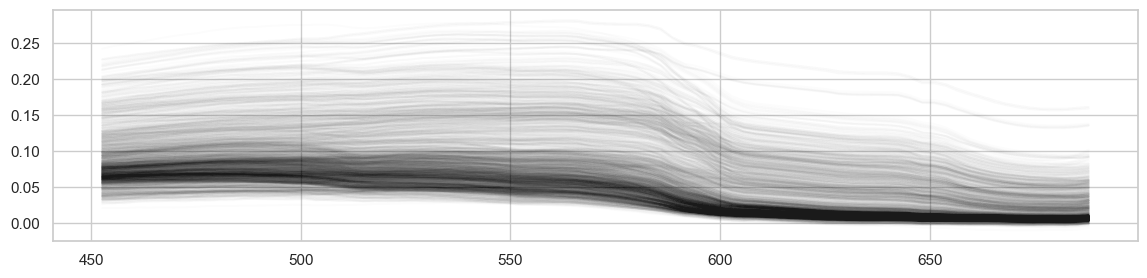

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(14,3))
ax.plot(validation_spectra.T, alpha=0.01, c='k');

Log-normal statistic: 0.23
Log-normal pvalue: 0.00
Gamma statistic: 0.12
Gamma pvalue: 0.00
Weibull statistic: 0.11
Weibull pvalue: 0.00


/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_29897/2544357211.py:26: MatplotlibDeprecationWarning:

Passing label as a length 6 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.



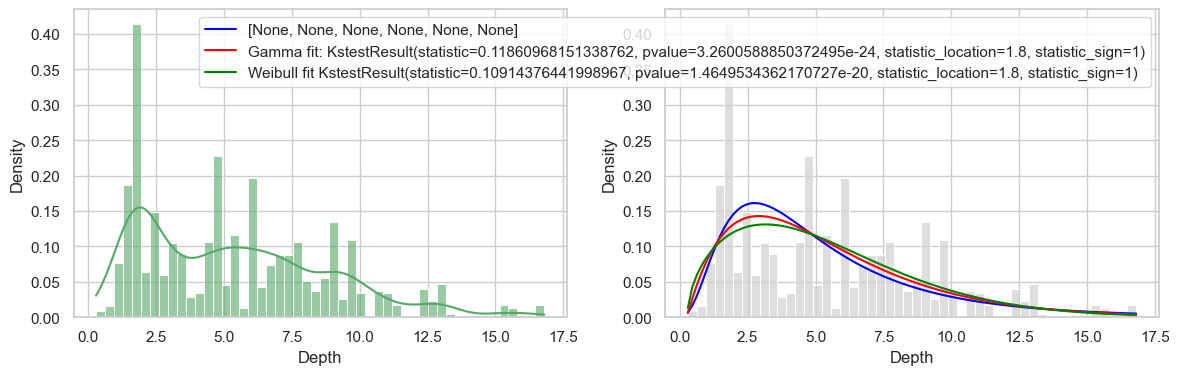

In [231]:
# fit a statistical model to the data distribution
from scipy.stats import norm
from scipy.stats import exponnorm
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

data = validation_data.Depth
sns.histplot(data, bins=50, stat="density", alpha=0.6, color='g', kde=True, ax=axes[0])

shape, loc, scale = stats.lognorm.fit(data)
lognorm_pdf = stats.lognorm.pdf(np.linspace(min(data), max(data), 100), shape, loc=loc, scale=scale)

alpha, loc, beta = stats.gamma.fit(data)
gamma_pdf = stats.gamma.pdf(np.linspace(min(data), max(data), 100), alpha, loc=loc, scale=beta)

c, loc, scale = stats.weibull_min.fit(data)
weibull_pdf = stats.weibull_min.pdf(np.linspace(min(data), max(data), 100), c, loc=loc, scale=scale)

lognorm_ks = stats.kstest(data, 'lognorm', args=(shape, loc, scale))
gamma_ks = stats.kstest(data, 'gamma', args=(alpha, loc, beta))
weibull_ks = stats.kstest(data, 'weibull_min', args=(c, loc, scale))

x = np.linspace(min(data), max(data), 100)
sns.histplot(data, bins=50, kde=False, stat='density', color='lightgray')
axes[1].plot(x, lognorm_pdf, label=[print(f"{dist} {stat}: {getattr(ks, stat):.2f}") for dist, ks in zip(["Log-normal", "Gamma", "Weibull"], [lognorm_ks, gamma_ks, weibull_ks]) for stat in ["statistic", "pvalue"]], color='blue')
axes[1].plot(x, gamma_pdf, label=f"Gamma fit: {gamma_ks}", color='red')
axes[1].plot(x, weibull_pdf, label=f"Weibull fit {weibull_ks}", color='green')
axes[1].legend()

In [233]:
# 
[print(f"{dist} {stat}: {getattr(ks, stat):.2f}") for dist, ks in zip(["Log-normal"], [lognorm_ks, gamma_ks, weibull_ks]) for stat in ["statistic", "pvalue"]]

Log-normal statistic: 0.23
Log-normal pvalue: 0.00
Gamma statistic: 0.12
Gamma pvalue: 0.00
Weibull statistic: 0.11
Weibull pvalue: 0.00


[None, None, None, None, None, None]

In [228]:
# for gamma_ks.stat in "statistic", "pvalue":
#     print(f"Gamma {gamma_ks.stat}: {getattr(gamma_ks, gamma_ks.stat):.2f}")
    
[print(f"{dist} {ks.stat}: {getattr(ks, ks.stat):.2f}") for dist, ks, stat in zip(["Log-normal", "Gamma", "Weibull"], [lognorm_ks, gamma_ks, weibull_ks], ["statistic", "pvalue"])]

AttributeError: 'KstestResult' object has no attribute 'stat'

In [213]:
**depth_lims

SyntaxError: invalid syntax (4257004689.py, line 1)

In [206]:
depth_lims = [0, 16.4]

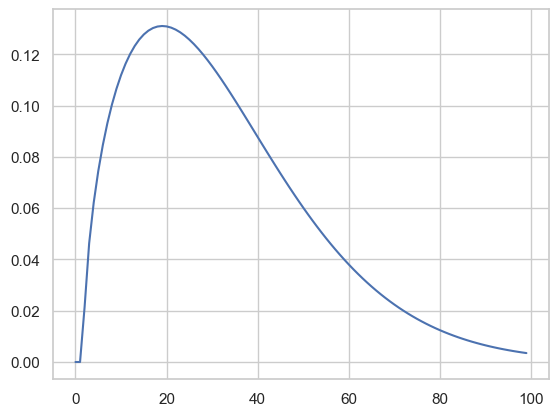

In [234]:
weibull_min_vals = {
    'c': 1.5341393039558309,
    'loc': 0.28062690149136393,
    'scale': 5.723423318320629
}
wei = stats.weibull_min.pdf(np.linspace(depth_lims[0], depth_lims[1], num=100), **weibull_min_vals)
plt.plot(wei)
# 

In [239]:
from scipy.interpolate import interp1d
# Interpolate wei to match the size of np.linspace(*depth_lims, 1000)
depths = np.linspace(*depth_lims, 100)
wei_interp = interp1d(depths, wei, kind='linear', fill_value="extrapolate")
wei_resampled = wei_interp(np.linspace(*depth_lims, 1000))

np.random.choice(
    np.linspace(*depth_lims, 1000), size=1000, p=wei_resampled / np.sum(wei_resampled)
)
    

array([11.9019019 ,  6.17257257,  8.94694695,  4.23543544,  4.87567568,
        2.77437437, 12.27947948, 10.83483483, 12.2958959 ,  6.5009009 ,
        8.94694695,  2.34754755,  1.51031031,  2.44604605,  1.65805806,
        4.90850851,  8.7991992 ,  1.65805806,  5.46666667, 13.26446446,
       14.18378378,  4.90850851, 13.13313313,  2.11771772,  8.56936937,
        6.09049049,  3.21761762, 12.70630631,  4.66226226, 10.03043043,
       14.2986987 ,  4.23543544,  1.95355355,  6.56656657,  3.95635636,
        3.66086086,  2.64304304,  4.46526527,  7.00980981,  1.96996997,
        9.42302302,  6.00840841,  5.6964965 ,  9.53793794,  3.93993994,
        4.6950951 ,  1.2968969 , 11.86906907,  8.35595596,  8.6022022 ,
        3.90710711,  5.02342342,  4.2026026 ,  3.2012012 ,  2.38038038,
        4.16976977,  4.82642643, 10.47367367,  8.81561562,  8.19179179,
        1.32972973,  2.59379379, 10.03043043,  7.27247247,  4.51451451,
        2.23263263,  6.25465465,  4.89209209,  6.56656657,  7.86

In [3]:
# load labels (recorded benthic cover)
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
validation_data.head()

X         Y Campaign         Locale  Station      TimeUTC  \
0  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
1  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
2  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
3  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
4  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   

      TimeLocal  Depth Metabolism Optics  ... othInvert  othOther  othSponge  \
0  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
1  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
2  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
3  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
4  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   

   othUrchin  sedLimest  sedMud  sedRubble  sedSand  ROInumber  \
0          0          0       0          0       27          1   
1          0          0       0          0       27          1   
2          0          0       0          0       27          1   
3          0          0       0          0       27          1   
4          0          0       0          0       27          1   

                         Flightline  
0  prm20160908t225710_corr_v1w2_img  
1  prm20160908t225710_corr_v1w2_img  
2  prm20160908t225710_corr_v1w2_img  
3  prm20160908t225710_corr_v1w2_img  
4  prm20160908t225710_corr_v1w2_img  

[5 rows x 34 columns]

In [4]:
(X_train, X_test), (y_train, y_test), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember").generate_data()
print("N train samples:", X_train.shape[0])
print("N features:", X_train.shape[1])
print("N test samples:", X_test.shape[0])
print("Label dimensions:", y_train.shape[1])

N train samples: 1550
N features: 84
N test samples: 388
Label dimensions: 3


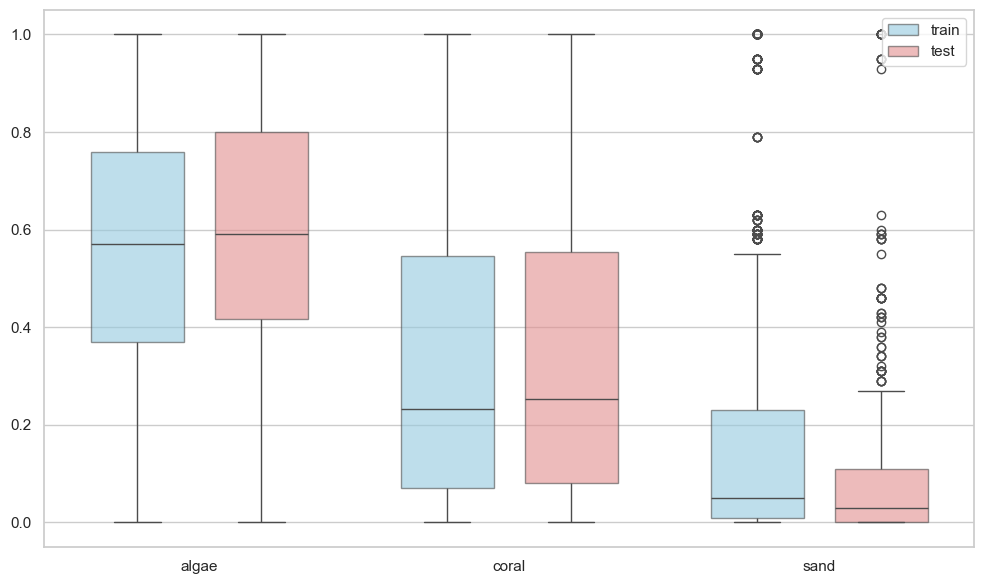

In [5]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=y_train, ax=ax, positions=np.arange(len(y_train.columns)) - 0.2, width=0.3, color="skyblue", boxprops=dict(alpha=0.6), label="train")
sns.boxplot(data=y_test, ax=ax, positions=np.arange(len(y_test.columns)) + 0.2, width=0.3, color="lightcoral", boxprops=dict(alpha=0.6), label="test")

plt.legend()
plt.tight_layout()

In [6]:
best_gbr = ml_utils.sklModels(model_type="gradient_boosting", n_iter_search=1000).return_fitted_model(X_train, y_train)
best_rf = ml_utils.sklModels(model_type="random_forest", n_iter_search=1000).return_fitted_model(X_train, y_train)
best_mlp = ml_utils.sklModels(model_type="mlp", n_iter_search=1000).return_fitted_model(X_train, y_train)

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 324 is smaller than n_iter=1000. Running 324 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV took 1616.11 seconds for 1000 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.723 (std: 0.017)
Parameters: {'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 4, 'estimator__max_features': 'log2', 'estimator__max_depth': 40}
Model with rank: 2
Mean validation score: 0.723 (std: 0.019)
Parameters: {'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 10}
Model with rank: 3
Mean validation score: 0.722 (std: 0.014)
Parameters: {'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 4, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 70}


/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV took 1559.78 seconds for 1000 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.727 (std: 0.020)
Parameters: {'n_estimators': 230, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': False}
Model with rank: 2
Mean validation score: 0.727 (std: 0.027)
Parameters: {'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': False}
Model with rank: 3
Mean validation score: 0.726 (std: 0.023)
Parameters: {'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}


/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 384 is smaller than n_iter=1000. Running 384 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization ha

RandomizedSearchCV took 15457.14 seconds for 1000 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.785 (std: 0.047)
Parameters: {'tol': 1e-09, 'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.0001, 'activation': 'relu'}
Model with rank: 2
Mean validation score: 0.772 (std: 0.042)
Parameters: {'tol': 1e-09, 'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.0001, 'activation': 'relu'}
Model with rank: 3
Mean validation score: 0.762 (std: 0.032)
Parameters: {'tol': 0.0001, 'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.0001, 'activation': 'relu'}


In [9]:
# predict
fitted_rf = best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R^2 for RandomForest: {r2_rf:.3f}")

y_pred_gbr = best_gbr.predict(X_test)
r2_gbr = r2_score(y_test, y_pred_gbr)
print(f"R^2 for MultiOutputGradientBoosted: {r2_gbr:.3f}")

y_pred_mlp = best_mlp.predict(X_test)
r2_mlp = r2_score(y_test, y_pred_mlp)
print(f"R^2 for MLP: {r2_mlp:.3f}")

R^2 for RandomForest: 0.796
R^2 for MultiOutputGradientBoosted: 0.778
R^2 for MLP: 0.813


In [34]:
tree.predict(X_test)

array([[0.28      , 0.27906977, 0.48      ],
       [0.79      , 0.24418605, 0.        ],
       [0.49      , 0.25581395, 0.29      ],
       ...,
       [0.78      , 0.25581395, 0.        ],
       [0.59      , 0.44186047, 0.02      ],
       [0.92      , 0.02325581, 0.05      ]])

In [48]:
predictions_std_dev

array([[0.19637559, 0.09249406, 0.21296036],
       [0.17072551, 0.19448531, 0.05073235],
       [0.11567035, 0.16016642, 0.0726634 ],
       ...,
       [0.12570681, 0.13644795, 0.09108458],
       [0.1838046 , 0.26293099, 0.28992115],
       [0.06893459, 0.05501379, 0.05948565]])

In [51]:
y_test.columns

Index(['algae', 'coral', 'sand'], dtype='object')

In [80]:
def get_model_std_dev(model, y_test: pd.DataFrame) -> pd.DataFrame:

    predictions = []
    for i, tree in enumerate(fitted_rf.estimators_):
        predictions.append(tree.predict(X_test))
        
    np.array(predictions).shape
    stds = np.std(predictions, axis=0)
    
    return stds
            
def generate_model_metadata(validation_data, model, y_test):
    std_dev_predictions = get_model_std_dev(model, y_test)
    predictions_std_dev = pd.DataFrame(std_dev_predictions, index=y_test.index, columns=[col + "_std_dev" for col in y_test.columns])
    metadata = pd.concat([validation_data.loc[y_test.index, ["Locale", "Depth"]], predictions_std_dev], axis=1)
    metadata_multiindex = pd.MultiIndex.from_product([["metadata"], metadata.columns], names=["source", "label"])
    return pd.DataFrame(metadata.values, index=y_test.index, columns=metadata_multiindex)
    

# Combine test_data with information from validation_data
test_data = y_test
# pred_data = pd.DataFrame(y_pred_rf, columns=labels.columns, index=y_test.index)
pred_data = y_pred_rf


generate_model_metadata(validation_data, fitted_rf, y_test)
# # get_std_dev(pred_data, test_data)
# predictions_std_dev = get_std_dev(pred_data[:,0], test_data.iloc[:,0])
# predictions_std_dev = 


# metadata_df = pd.DataFrame(metadata.values, index=y_test.index, columns=metadata_multiindex)

# metadata_df
# # # Convert predictions to a numpy array
# # predictions = np.array(predictions)
# # std_dev_predictions = pd.Series(np.std(predictions, axis=0), index=y_test.index, name="std_dev")

# # Fetch df indices of test_data to select metadata
# metadata = pd.concat([validation_data.loc[y_test.index, ["Locale", "Depth"]], std_dev_predictions], axis=1)


source       metadata                                               
label          Locale Depth algae_std_dev coral_std_dev sand_std_dev
582      Heron Island  11.3      0.196376      0.092494      0.21296
901              Maui  10.1      0.170726      0.194485     0.050732
907              Maui   7.6       0.11567      0.160166     0.072663
1754            Palau   6.1      0.042185      0.089808     0.047023
1464      Kaneohe Bay   5.8      0.188257      0.252089     0.056305
...               ...   ...           ...           ...          ...
1914            Palau   2.0      0.091913       0.10635     0.016605
1639            Palau   0.9       0.07851      0.106032     0.108639
1263      Kaneohe Bay   5.5      0.125707      0.136448     0.091085
530      Heron Island   7.9      0.183805      0.262931     0.289921
192     Lizard Island   3.4      0.068935      0.055014     0.059486

[388 rows x 5 columns]

In [17]:
# # Combine test_data and pred_data in a multiindex dataframe
# data_multiindex = pd.MultiIndex.from_product([["true", "pred"], labels.columns], names=["source", "label"])
# combined_data = np.hstack([test_data, pred_data])
# data_df = pd.DataFrame(combined_data, index=y_test.index, columns=data_multiindex)

# # Concatenate data_df and metadata_df
# results_df = pd.concat([data_df, metadata_df], axis=1)
# results_df

In [12]:
test_data = y_test
pred_data = y_pred_mlp

# plotting.plot_regression_results(test_data, pred_data, labels, metadata=metadata, color_by="Depth")

In [61]:
labels.shape

(1938, 3)

TypeError: expected 1D vector for x

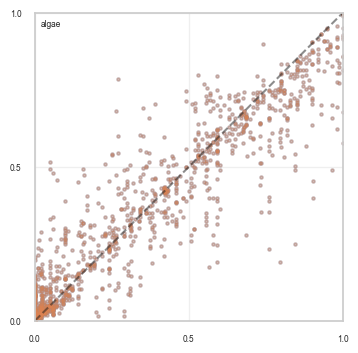

In [68]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plotting.plot_regression_axis(fig, axes, test_data, pred_data, labels, 
                            #   metadata=metadata,
                              color_by="Depth")

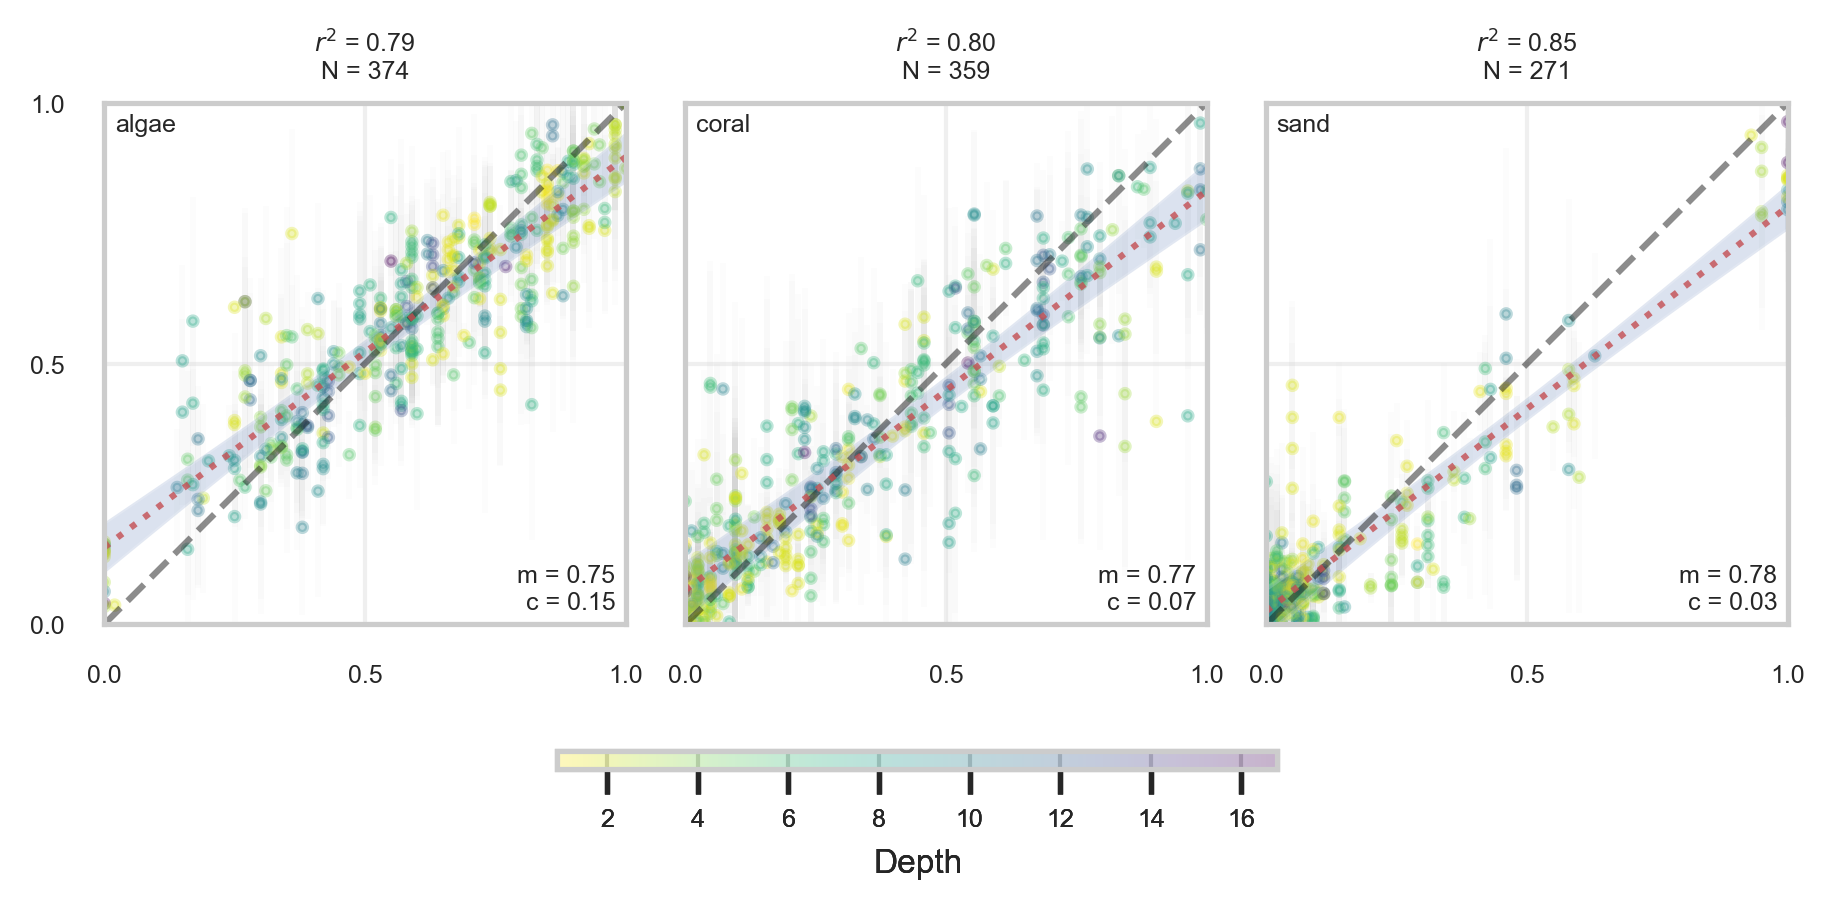

In [78]:
test_data = y_test
pred_data = y_pred_mlp

plotting.plot_regression_results(test_data, pred_data, labels,
                                 metadata=metadata, 
                                 color_by="Depth")

In [94]:
errors_df = test_data - pred_data
# errors_df["Depth"] = metadata["Depth"]


In [98]:
from scipy.stats import pearsonr, spearmanr

# for each label, run a statistical test to see dependence on depth
correlation_results = {}

# Loop through each target and compute the correlation with depth
for target in errors_df.columns:
    # Pearson correlation
    pearson_corr, pearson_p = pearsonr(metadata["Depth"], errors_df[target])
    
    # Spearman correlation (alternative to Pearson if you prefer a rank-based test)
    spearman_corr, spearman_p = spearmanr(metadata["Depth"], errors_df[target])
    
    # Store the results in a dictionary
    correlation_results[target] = {
        'Pearson Correlation': pearson_corr,
        'Pearson p-value': pearson_p,
        'Spearman Correlation': spearman_corr,
        'Spearman p-value': spearman_p
    }

# Convert the results dictionary into a DataFrame for easy viewing
correlation_df = pd.DataFrame(correlation_results).T
correlation_df


Pearson Correlation  Pearson p-value  Spearman Correlation  \
algae            -0.127788         0.011757             -0.122643   
coral             0.049309         0.332679              0.105318   
sand              0.117922         0.020157              0.082346   
Depth             1.000000         0.000000              1.000000   

       Spearman p-value  
algae          0.015644  
coral          0.038117  
sand           0.105331  
Depth          0.000000

In [193]:
# test the statistical significance on depth on the accuracy of the model
import statsmodels.api as sm

# calculate error for each class
error = test_data - pred_data
error_df = pd.DataFrame(error, columns=labels.columns)
error_df["Depth"] = metadata["Depth"]
error_df = error_df.melt(id_vars="Depth", var_name="label", value_name="error")
error_df['intercept'] = 1

error_df

Depth  label     error  intercept
0      11.3  algae -0.268383          1
1      10.1  algae -0.072241          1
2       7.6  algae  0.130832          1
3       6.1  algae  0.072937          1
4       5.8  algae  0.038203          1
...     ...    ...       ...        ...
1159    2.0   sand -0.037806          1
1160    0.9   sand  0.162448          1
1161    5.5   sand -0.071375          1
1162    7.9   sand -0.021844          1
1163    3.4   sand -0.022008          1

[1164 rows x 4 columns]

In [195]:
# Fit the regression model
model = sm.OLS(error_df['error'], error_df[['intercept', 'Depth']]).fit()
print(model.summary())

# ANOVA
from statsmodels.formula.api import ols
model = ols("error ~ Depth", data=error_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03058
Date:                Mon, 30 Sep 2024   Prob (F-statistic):              0.861
Time:                        15:18:04   Log-Likelihood:                 636.75
No. Observations:                1164   AIC:                            -1270.
Df Residuals:                    1162   BIC:                            -1259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0022      0.008     -0.274      0.7

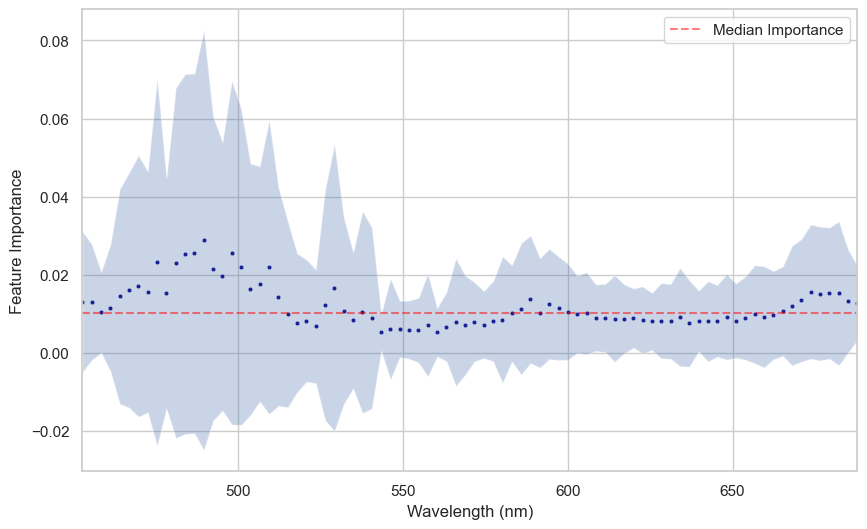

In [81]:
# plot a scatterplot of mean importance, with std shaded
rf_importances = np.array([tree.feature_importances_ for tree in best_rf.estimators_])
importance_df = pd.DataFrame(rf_importances, columns=X_train.columns).agg(["mean", "std"]).T

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=importance_df.index, y=importance_df["mean"], s=10, ax=ax, color="darkblue")
ax.fill_between(importance_df.index, importance_df["mean"] - importance_df["std"], importance_df["mean"] + importance_df["std"], alpha=0.3)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Feature Importance")
ax.set_xlim(min(importance_df.index), max(importance_df.index))
ax.hlines(np.median(importance_df["mean"]), min(importance_df.index), max(importance_df.index), linestyle="--", alpha=0.5, color="red", label="Median Importance")
ax.legend()